# Data Description

This exercise studies the prediction of the maximum temperature in a nuclear fuel rod based on several input features.
The model neglects the helium gap and cladding regions.
The data is generated via the perturbation of the input features.
Additionally, a noise correction (step function) is applied to the data.

#### Input:
* qprime: linear heat generation rate [W/m]
* mdot: mass flow rate [g/s]
* Tin: temperature at fuel boundary [K]
* R: fuel radius [m]
* L: fuel length [m]
* cp: heat capacity [J/g/K]
* k: thermal conductivity [W/m/K]

#### Output:
* T: fuel centerline or Tmax [K]

## EDA

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('heat.csv')
data.head()

,qprime,mdot,Tin,R,L,Cp,k,T
0,35987.992759,206.185816,573.151869,0.004901,3.448155,4.096140,0.960945,1034.133784
1,38481.055798,192.378974,573.150960,0.004966,3.436833,4.249182,1.011272,1170.316042
2,39143.292108,205.076928,573.153975,0.005210,3.681457,4.237540,0.994646,1164.893565
3,38687.579644,199.594924,573.150777,0.004864,3.624594,4.158921,1.028158,1205.250040
4,40469.561181,194.142084,573.150977,0.004914,3.731222,4.244278,1.018738,1444.718666


In [3]:
data.shape

(1000, 8)

<AxesSubplot:xlabel='qprime', ylabel='T'>

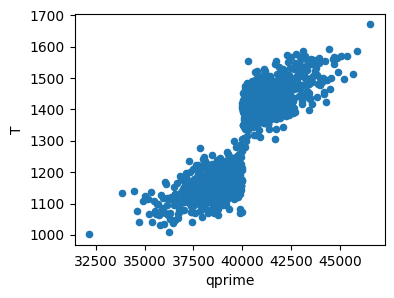

In [20]:
data.plot.scatter(x='qprime', y='T', figsize=(4, 3))

<AxesSubplot:xlabel='mdot', ylabel='T'>

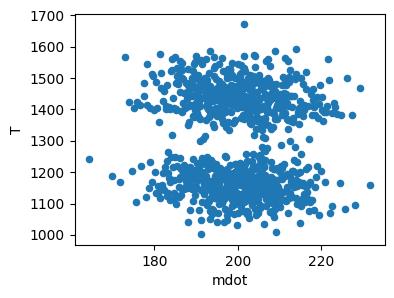

In [21]:
data.plot.scatter(x='mdot', y='T', figsize=(4, 3))

<AxesSubplot:xlabel='Tin', ylabel='T'>

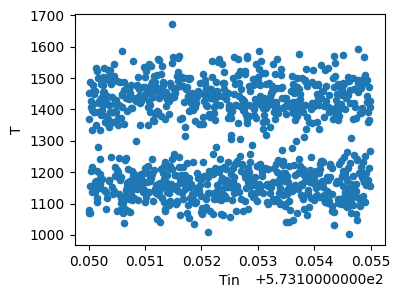

In [22]:
data.plot.scatter(x='Tin', y='T', figsize=(4, 3))

Data were affected by a step function that can be clearly seen in the figures above.

## Train/Test Models

In [61]:
from sklearn.preprocessing import StandardScaler

In [24]:
X = data[data.columns[:-1]]  # all columns but T
Y = data[['T']]

In [38]:
# here we assume that the data was randomly generated
xtrain = X.loc[:899]
xtest = X.loc[900:]

ytrain = Y.loc[:899]
ytest = Y.loc[900:]

In [41]:
# Scale data
xscaler = StandardScaler()
Xtrain = xscaler.fit_transform(xtrain)
Xtest = xscaler.transform(xtest)

yscaler = StandardScaler()
Ytrain = yscaler.fit_transform(ytrain)
Ytest = yscaler.transform(ytest)

### Random Forest

In [66]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [50]:
rf_model = RandomForestRegressor(max_features=6, random_state=1)
rf_model.fit(Xtrain, Ytrain.reshape(-1,))
rf_model.score(Xtest, Ytest)

0.9962553096896379

In [63]:
Ypred1 = rf_model.predict(Xtest)
Yreal1 = yscaler.inverse_transform(Ypred1.reshape(-1, 1))
mean_absolute_error(ytest, Yreal1)

7.270862611440741

<BarContainer object of 7 artists>

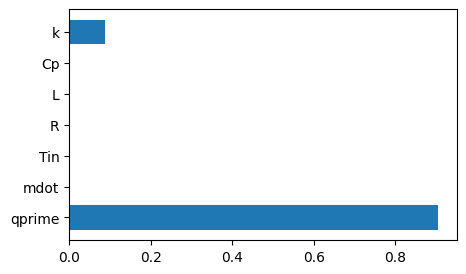

In [59]:
plt.figure(figsize=(5, 3))
plt.barh(data.columns[:7], rf_model.feature_importances_)

### SVM

In [65]:
from sklearn.svm import SVR

In [67]:
svm_model = SVR(kernel='rbf', C=1.1, epsilon=0.2)
svm_model.fit(Xtrain, Ytrain.reshape(-1,))
svm_model.score(Xtest,Ytest)

0.873558584613678

In [68]:
Ypred2 = svm_model.predict(Xtest)
Yreal2 = yscaler.inverse_transform(Ypred2.reshape(-1, 1))
mean_absolute_error(ytest, Yreal2)

44.67176364348681

### LR

In [69]:
from sklearn.linear_model import LinearRegression

In [71]:
lr_model = LinearRegression()
lr_model.fit(Xtrain, Ytrain)
lr_model.score(Xtest, Ytest)

0.8396003824699714

In [72]:
Ypred3 = lr_model.predict(Xtest)
Yreal3 = yscaler.inverse_transform(Ypred3)
mean_absolute_error(ytest, Yreal3)

52.953821105579934

### FNN

In [75]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [76]:
model = Sequential()

model.add(Dense(100, activation='relu', input_dim = Xtrain.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))
                
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=5e-4), metrics=['mean_absolute_error'])
model.summary()

history = model.fit(Xtrain, Ytrain, epochs=100, batch_size=32, validation_split=0.15, verbose=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               800       
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 7,151
Trainable params: 7,151
Non-trainable params: 0
_________________________________________________________________


In [78]:
Ypred4 = model.predict(Xtest)
r2_score(Ytest, Ypred4)

4/4 [==============================] - 0s 2ms/step


0.9832969385966163

In [79]:
Yreal4 = yscaler.inverse_transform(Ypred4)
print(mean_absolute_error(ytest, Yreal4))

9.679899330681337
